# Opacity Package

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
plt.style.use(['seaborn', {'figure.dpi':100}])

import lp_opac

# Comparison of Optical Constants
This part compares the actual optical constants that the package uses to the files I received from Luca Ricci.

### Silicates
There are some differences, Lucas data seems to be identical with [Weingartner & Draine 2001](https://dx.doi.org/10.1086/32085). We are using the [Draine 2003](https://dx.doi.org/10.1086/379123) implemented in `diel_draine2003_astrosil`.

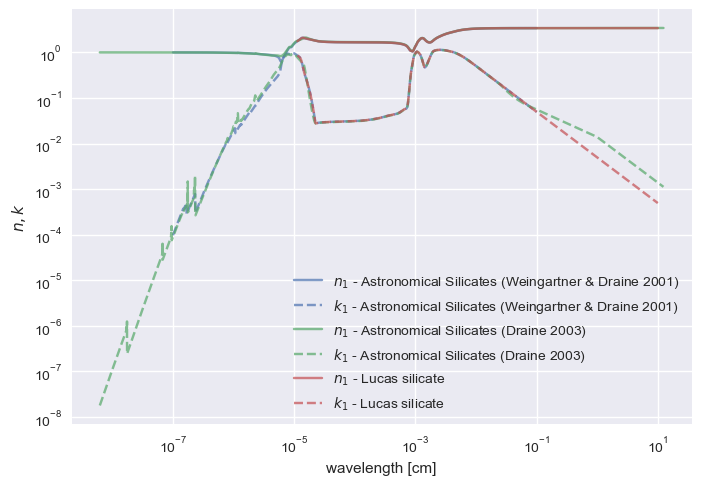

In [2]:
r = lp_opac.diel_luca('silicate', extrapol=True)
c1 = lp_opac.diel_WD2001_astrosil()
c2 = lp_opac.diel_draine2003_astrosil()
lp_opac.compare_nk([c1, c2, r], orig_data=True);

### Carbonaceous Material
Comparing the carbonaceous grain data: good match, but the data in Zubko ends at 0.9 mm (1.358 meV). Data beyond that is apparently extrapolated. Our version of the Zubko et al. 1996 data uses the extrapolation with default parameters to give a similar result

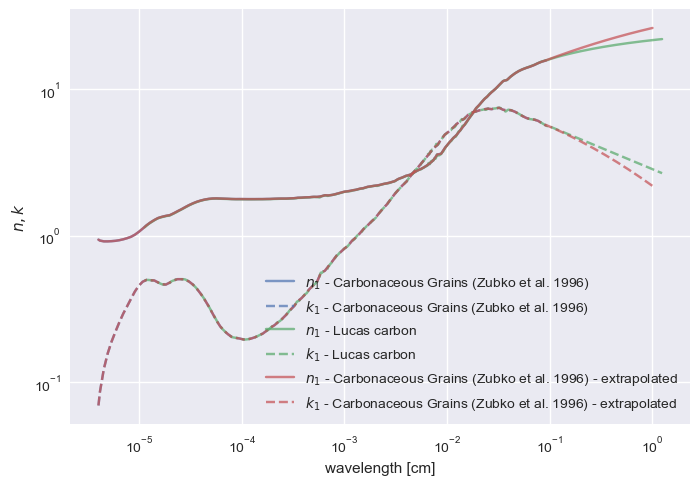

In [3]:
r = lp_opac.diel_luca('carbon')
c = lp_opac.diel_zubko_carbon()
ce = lp_opac.diel_zubko_carbon(extrapol=True)
lp_opac.compare_nk([c, r, ce], orig_data=True);

### Water Ice
And now the water ice comparison: it is unclear to me where Luca Ricci data comes from. His thesis mentions only Warren 1984, but those constants only go to 4.43e-6 cm, while his extends down to 4.14e-09. The header mentions *extended to X-rays by V. Zubko*. Furthermore his long wavelengths $k$ values are neither the old Warren 1984 data nor the new ones. It looks like they are somewhere between the -20 and -5 ºC data of Warren 1984. We will use the newer values from Warren & Brandt (2008).

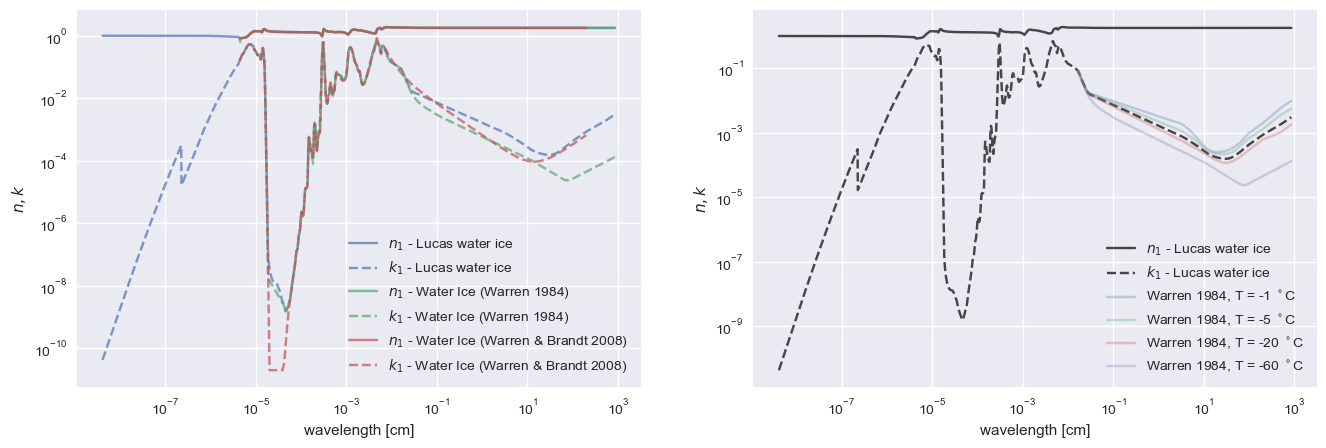

In [4]:
file = os.path.join(os.path.dirname(lp_opac.__file__),'optical_constants', 'warren', 'warren_1984_all_temps.txt')
lam, n1, k1, n2, k2, n3, k3, n4, k4 = np.loadtxt(file).T
T = [-1,-5,-20,-60]

r = lp_opac.diel_luca('ice')
c = lp_opac.diel_warren(new=True)
co = lp_opac.diel_warren(new=False)

f, axs = plt.subplots(1, 2, figsize=(16, 5))

lp_opac.compare_nk([r, co, c], orig_data=True, ax=axs[0])

ax = lp_opac.compare_nk([r], orig_data=True, ax=axs[1])

for l in ax.get_lines()[:2]:
    l.set_color('k')
for _T,k in zip(T,[k1, k2, k3, k4]):
    ax.loglog(lam*1e-4,k,'-',label=f'Warren 1984, T = {_T} $^\circ$C', alpha=0.3)
ax.legend();

# Comparison of mixed optical constants

We will compare how the Bruggeman-mixed optical constants based on Lucas data and our optical constants. Only differences are in the long wavelength tail that comes from the extrapolation of the carbonaceous data.

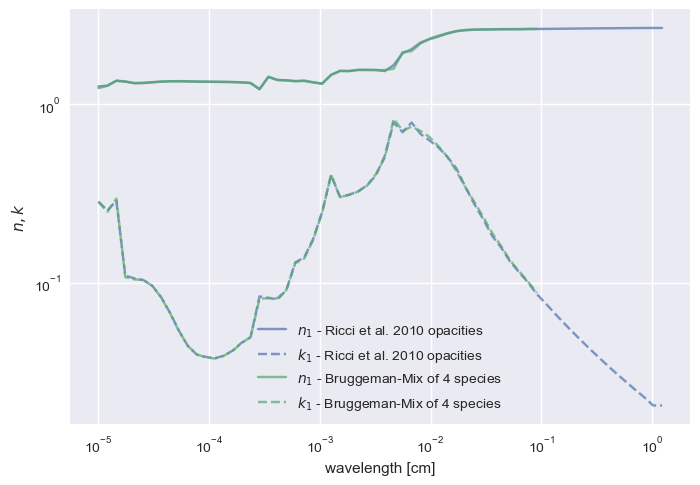

In [5]:
# after Lucas thesis, the fractions in Ricci+2010 are typos

r1 = lp_opac.diel_luca('silicate', extrapol=True, lmin=1e-6, lmax=1.0)
r2 = lp_opac.diel_luca('carbon', extrapol=True, lmin=1e-6, lmax=1.0)
r3 = lp_opac.diel_luca('ice', extrapol=True, lmin=1e-6, lmax=1.0)
r4 = lp_opac.diel_vacuum()

vol_fract = [0.07, 0.21, 0.42, 0.30]
densities = [3.50, 2.50, 1.00, 0.00]
rho_ricci = np.sum(vol_fract * np.array(densities))

dc_ricci = lp_opac.diel_mixed([r1, r2, r3, r4], vol_fract, rule='Bruggeman')
dc_ricci.material_str='Ricci et al. 2010 opacities'
dc_lit, rho_lit = lp_opac.get_default_diel_constants()

lp_opac.compare_nk([dc_ricci, dc_lit]);

# Compare old (Luca Riccis files) and new opacities (literature data, this Mie code)

Set up particle size and wavelength grid

In [6]:
a = np.logspace(-5, 2, 200)
lam = np.logspace(np.log10(6.5e-6), 0, 206)

Calculate opacities

In [7]:
kappa_abs_l, kappa_sca_l, gg_sca_l, _, _, _ = lp_opac.get_opacities(a, lam, extrapol=True, return_all=True, diel_const=dc_ricci, rho_s=rho_ricci)
kappa_abs_r, kappa_sca_r, gg_sca_r, _, _, _ = lp_opac.get_opacities(a, lam, extrapol=True, return_all=True)

Mie ... Done!
Note: wavelength range outside data. Extrapolation will be done but is uncertain.
Mie ... Done!


Load new opacities

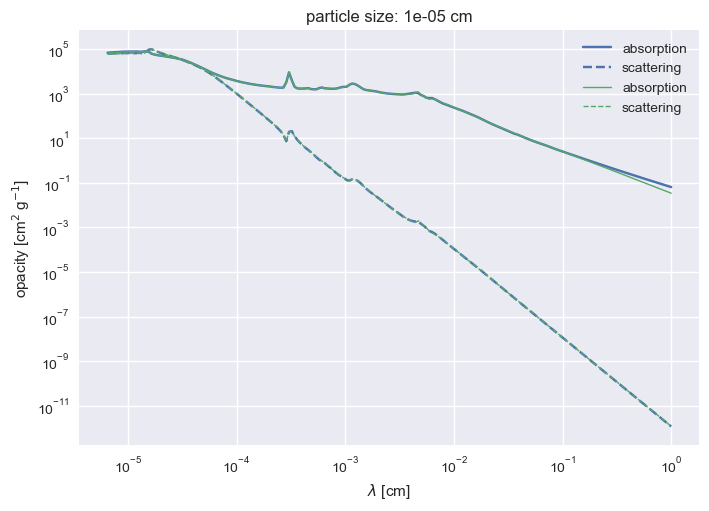

In [8]:
f, ax = plt.subplots()

ax.loglog(lam, kappa_abs_l[0, :], c='C0', ls='-', label='absorption')
ax.loglog(lam, kappa_sca_l[0, :], c='C0', ls='--', label='scattering')

ax.loglog(lam, kappa_abs_r[0, :], c='C1', lw=1, ls='-', label='absorption')
ax.loglog(lam, kappa_sca_r[0, :], c='C1', lw=1, ls='--', label='scattering')

ax.set_title(f'particle size: {a[0]} cm')
ax.set_ylabel('opacity [cm$^2$ g$^{-1}$]')
ax.set_xlabel('$\lambda$ [cm]')
ax.legend();

# Package Tests

## Test the extrapolation of optical constants

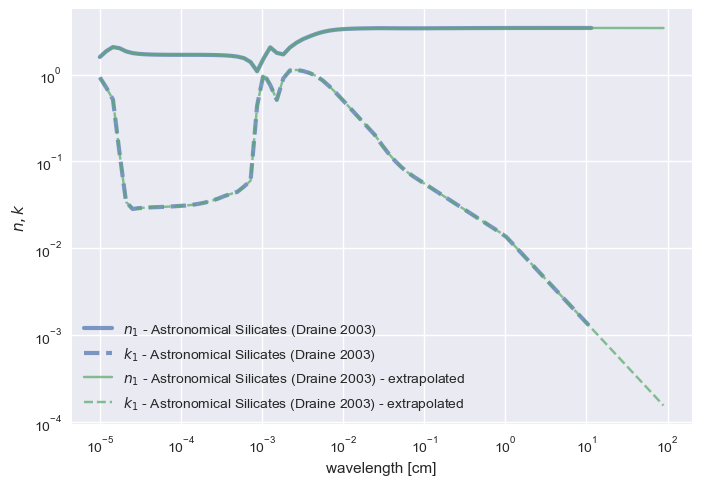

In [9]:
dc_ext = lp_opac.diel_draine2003_astrosil()
dc_ext.extrapolate_constants(1e0,1e2)
dc_orig = lp_opac.diel_draine2003_astrosil()
lp_opac.compare_nk([dc_orig, dc_ext])
ax = plt.gca()
for l in ax.get_lines()[-4:-2]: l.set_linewidth(3)
ax.legend();

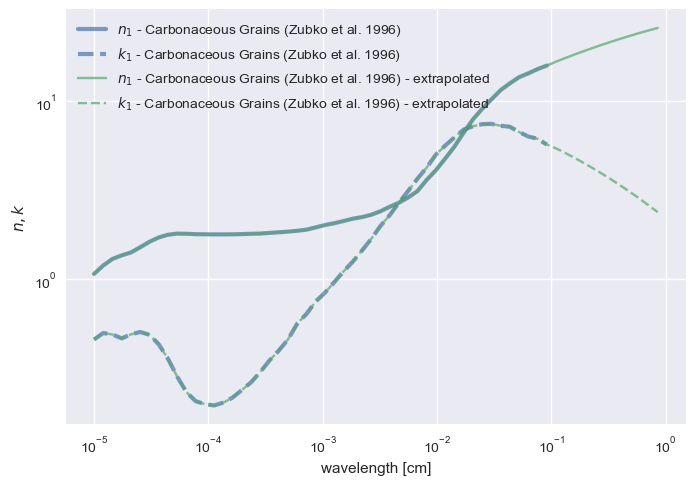

In [10]:
dc_orig = lp_opac.diel_zubko_carbon(extrapol=False)
dc_extr = lp_opac.diel_zubko_carbon(extrapol=False)
dc_extr.extrapolate_constants(5e-2, 1)
lp_opac.compare_nk([dc_orig, dc_extr])
ax = plt.gca()
for l in ax.get_lines()[-4:-2]: l.set_linewidth(3)
ax.legend();

# Compare the different BH Mie implementations

In [11]:
x = 1
dc = lp_opac.get_default_diel_constants()[0]
n,k = dc.nk(1e-4)

**Time the python version without numba (but coating)**

In [12]:
res = lp_opac.lp_opac.bhmie_pymiecoated(x, complex(n,k), 3)
print(f' Qext = {res[2]}')
print(f' QABS = {res[3]}')
print(f' QSCA = {res[4]}')
print(f' GSCA = {res[6]}')

 Qext = 0.19773563295965463
 QABS = 0.10608266446106457
 QSCA = 0.09165296849859006
 GSCA = 0.1868362054741506


In [13]:
%timeit res = lp_opac.lp_opac.bhmie_pymiecoated(x, complex(n,k), 3)

557 µs ± 174 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


**Time the python version with numba**

In [14]:
res = lp_opac.bhmie_python(x, complex(n,k),np.linspace(0, 180, 3))
print(f' Qext = {res[2]}')
print(f' QABS = {res[3]}')
print(f' QSCA = {res[4]}')
print(f' GSCA = {res[6]}')

 Qext = 0.1977356329596549
 QABS = 0.10608266446106444
 QSCA = 0.09165296849859046
 GSCA = 0.18683620547415275


In [15]:
%timeit res = lp_opac.bhmie_python(x, complex(n,k),np.linspace(0, 180, 3))

58 µs ± 13 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


**Time the fortran version**

In [16]:
res = lp_opac.bhmie_fortran(x, complex(n,k), 3)
print(f' Qext = {res[2]}')
print(f' QABS = {res[3]}')
print(f' QSCA = {res[4]}')
print(f' GSCA = {res[6]}')

 Qext = 0.19773562252521515
 QABS = 0.10608266294002533
 QSCA = 0.09165295958518982
 GSCA = 0.18683621287345886


In [17]:
%timeit res = lp_opac.bhmie_fortran(x, complex(n,k), 3)

3.22 µs ± 787 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
